# Predict GPU performance from other GPUs
### Use model trained on training data set from 5 GPUs, test on (all) data from remaining GPU

In [9]:
import os
import sys
import tensorflow as tf
import numpy as np
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [10]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  # To find local version of the library

In [8]:
from prediction import dnn_tools
from prediction.dnn_tools import dnn
from prediction_model import dataprep

In [13]:
predict = '1080ti'
model_name = 'only_%s' %predict

prediction_model = 'no_%s' %predict
path = '/models/data'

In [14]:
# Set paths
PREDICTION_PATH = os.path.join(ROOT_DIR, 'prediction/models/%s/saved_model' %prediction_model)
SCALER_PATH = os.path.join(ROOT_DIR, 'prediction/models/%s/scaler_Conv.save' %prediction_model)
DATA_PATH = os.path.join(ROOT_DIR, 'prediction_model/data/Data_convolution_%s.pkl' %prediction_model)

In [15]:
scaler = joblib.load(SCALER_PATH)
df = pd.read_pickle(DATA_PATH)
tfmodel_file = PREDICTION_PATH

In [16]:
df.describe()

,batchsize,channels_in,channels_out,gpu,kernelsize,matsize,padding,precision,strides,timeUsed_max,...,opt_SGD,act_None,act_relu,act_sigmoid,act_tanh,peak_performance,IO,bandwidth,cores,clock
count,110567.000000,110567.000000,110567.000000,110567.000000,110567.000000,110567.000000,110567.000000,110567.0,110567.000000,110567.000000,...,110567.000000,110567.000000,110567.000000,110567.000000,110567.000000,110567.000000,110567.000000,110567.000000,110567.000000,110567.000000
mean,16.158745,67.034097,67.111661,0.113054,3.991688,255.965351,0.500547,32.0,2.495211,17.352561,...,0.083687,0.250518,0.251893,0.249740,0.247850,8239.451211,79.776755,489.163168,3678.798629,1138.671584
std,9.062956,329.118098,329.264673,0.316660,2.007955,147.928524,0.500002,0.0,1.119003,35.988226,...,0.276919,0.433313,0.434102,0.432864,0.431766,3799.249323,118.744715,272.705615,966.705340,233.716245
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,32.0,1.000000,0.148177,...,0.000000,0.000000,0.000000,0.000000,0.000000,4291.000000,15.750000,240.000000,2496.000000,875.000000
25%,8.000000,10.000000,10.000000,0.000000,2.000000,128.000000,0.000000,32.0,1.000000,1.751561,...,0.000000,0.000000,0.000000,0.000000,0.000000,5591.000000,15.750000,288.000000,2880.000000,875.000000
50%,16.000000,19.000000,19.000000,0.000000,4.000000,255.000000,1.000000,32.0,2.000000,5.262980,...,0.000000,0.000000,0.000000,0.000000,0.000000,7365.000000,15.750000,320.000000,3584.000000,1178.000000
75%,24.000000,39.000000,38.000000,0.000000,6.000000,385.000000,1.000000,32.0,3.000000,16.559348,...,0.000000,1.000000,1.000000,0.000000,0.000000,8071.000000,15.750000,732.000000,4096.000000,1303.000000
max,32.000000,9978.000000,9908.000000,1.000000,7.000000,512.000000,1.000000,32.0,4.000000,756.834478,...,1.000000,1.000000,1.000000,1.000000,1.000000,14900.000000,300.000000,900.000000,5120.000000,1455.000000


In [17]:
data_cols_conv = ['batchsize','elements_matrix','elements_kernel','channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid',
#                       'ops','memory_weights','memory_in','memory_out',
                      'bandwidth','cores','clock']
split=[0,0,1]

In [18]:
data, time, train, test, validation = dataprep.data_preprocess_keep(df,data_cols_conv,split,scaler)

Size of train dataset: 0 
Size of test dataset: 0 
Size of validation dataset: 110567


INFO:tensorflow:Restoring parameters from /Users/djustus/workspace/newcastle/ml-performance-prediction/prediction/models/no_1080ti/saved_model/variables/variables


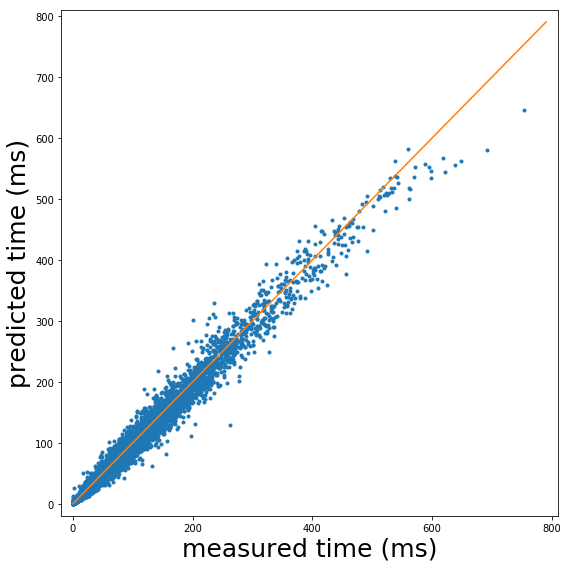

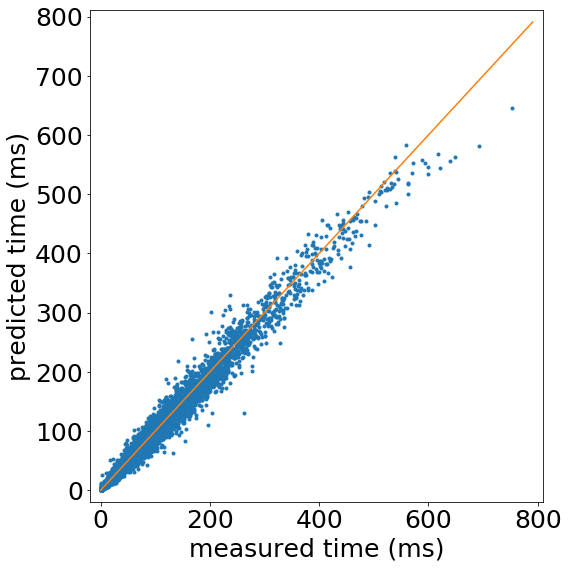

In [20]:
with tf.Session() as sess:
    tf.saved_model.loader.load(sess, ["serve"], tfmodel_file)
    graph = tf.get_default_graph()


    run = sess.run(
            'model_prediction:0',
            feed_dict={'model_input:0': data['Validation'], 
                       'model_targets:0': time['Validation'],
                       'model_istraining:0': False})
RMS_validation_error=np.sqrt(np.mean((time['Validation']-run)**2))
perc_error = np.mean(np.abs(time['Validation']-run)/time['Validation'])*100

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Validation'],run,'.')


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 

plt.xlabel('measured time (ms)',fontsize=25)
plt.ylabel('predicted time (ms)',fontsize=25)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()
ax.ticklabel_format(useOffset=False)
ax.plot([0,axlim],[0,axlim],2)
#plt.title('RMS error = %.3f' %RMS_validation_error)

#plt.savefig('figures/prediction_%s_from_other.png' %predict, dpi=300)

plt.show()

In [50]:
RMS_validation_error

4.244198

In [51]:
perc_error

25.55464208126068